In [1]:
#___________________________________________________________________________________________________________________
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import copy as cp
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_plot  import *
from colormap_c2c    import *
from sub_fesom_data_netcdf4  import * 
from sub_fesom_paperplot import *
#___________________________________________________________________________________________________________________
# LOAD FESOM2.0 MESH
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['use_cavity'] = False
# inputarray['use_cavity'] = True
# set plot box for cyl projection (default: [-180,180,-90,90])
# inputarray['which_box'] = [0,360,-90,90] ; inputarray['mesh_focus']=180
inputarray['which_box'],inputarray['proj'] = [-180,180,-90,90], 'cyl' # 'ortho', 'cyl', 'npstere' , 'spstere'
#inputarray['which_box'],inputarray['proj'],inputarray['mesh_focus'] = [0,360,-90,90], 'cyl', 180 # 'ortho', 'cyl', 'npstere' , 'spstere'

# inputarray['which_box'],inputarray['proj'] = [-70, 15,-90,-55], 'cyl'
# inputarray['which_box'],inputarray['proj'] = [-120, -60,-90,-65], 'cyl'
# inputarray['which_box'],inputarray['proj'] = [-180, 180,78,90], 'npstere'
# inputarray['which_box'],inputarray['proj'] = [-180, 180,-90,-60], 'spstere'

inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2','/work/ollie/pscholz/mesh_fesom2.0/core2_meanz/'
# inputarray['mesh_id'],inputarray['mesh_dir'] = 'mehmet','/work/ollie/pscholz/mesh_fesom2.0/mesh_mehmet_tss/'
# inputarray['mesh_alpha'],inputarray['mesh_beta'],inputarray['mesh_gamma'] = 0,0,0
# inputarray['mesh_id'],inputarray['mesh_dir'] = '72k_cavity','/work/ollie/pscholz/mesh_fesom2.0/cavity_72k/'

try:
	mesh
except NameError:
    mesh = fesom_init_mesh(inputarray)
    mesh.fesom_calc_nodearea()
    mesh.fesom_calc_landmask()
else:
    if mesh.id!=inputarray['mesh_id']:
        mesh = fesom_init_mesh(inputarray)
        mesh.fesom_calc_nodearea()
        mesh.fesom_calc_landmask()
    else:
        print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> rotate mesh rot2geo
 --> change mesh focus
 --> remove cyclic boundary
_______________________________________________________________
 --> calc. triangle area on nodes m^2 --> calc. triangle area m^2 >> time:0.051 s
 >> time:0.568 s
 --> calc landmask contourline


 --> path          : ../results/new_linfs/new_fesom_kpp/3/
 --> year/month/rec: [1989, 2009] , [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] , []
 --> depth         : [250]
 --> var           : temp --> var_list: ['temp', [], []]
 --> nti/nsi/ndi   : [1, 126858, 47]
 --> sel_levidx    : [15, 16]
 --> sel_timeidx   : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


___PLOT 2D DATA____________________________________________


<IPython.core.display.Javascript object>


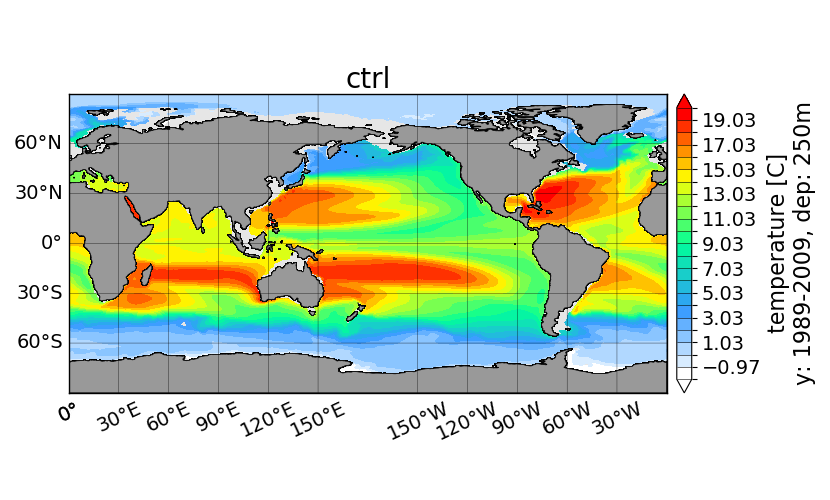

/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_fesom_plot.py:76: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  llcrnrlat  = inputarray['which_box'][2], urcrnrlat  = inputarray['which_box'][3],


[cmin,cmax,cref] = [-1.83, 19.9, 9.03]
-1.83 19.9 9.03 20 wbgyr
clevel =  [-1.97 -0.97  0.03  1.03  2.03  3.03  4.03  5.03  6.03  7.03  8.03  9.03
 10.03 11.03 12.03 13.03 14.03 15.03 16.03 17.03 18.03 19.03 20.03]


/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_fesom_plot.py:251: RuntimeWarning: invalid value encountered in less
  data_plot[data_plot<clevel[0]]  = clevel[0]+np.finfo(np.float32).eps
/home/ollie/pscholz/fesom2.0_githup/view_pscholz/sub_fesom_plot.py:252: RuntimeWarning: invalid value encountered in greater
  data_plot[data_plot>clevel[-1]] = clevel[-1]-np.finfo(np.float32).eps


In [2]:
#___________________________________________________________________________________________________________________
# SET INPUT PARAMETER
data1			= fesom_data(inputarray) # init fesom2.0 data object

# select variable: plot scalar: 'temp', 'salt', ...; plot norm: 'norm_uv', 'norm_uvwind',...;pülot vector: 'vec_uv'
data1.var 		= 'temp'

# select year to average over [start_yr, end_yr]
# data1.year		= [1948, 1950] 
data1.year		= [1989,2009]

# select month to averager over
data1.month		= list(range(1,12+1))
# data1.month		= [6,7,8]
# data1.record	= [1]

# select linear interpolated depth layers to average overfig.patch.set_facecolor('blue')
data1.depth		=  [250]
# data1.depth		= np.arange(   0, 100+1,5)
# data1.depth		= np.arange(   0, 250+1,10)
# data1.depth		= np.arange( 250, 500+1,10)
# data1.depth	    = np.arange( 500,1000+1,50)
# data1.depth	    = np.arange(1000,2000+1,50)
# data1.depth	    = np.arange(2000,4000+1,50)

# select description and path
data1.descript,data1.path = 'ctrl' ,'../results/new_linfs/new_fesom_kpp/3/'
    
# make anomaly
# do_anomaly      = True
do_anomaly      = False
if do_anomaly==True:
    data2 			= cp.deepcopy(data1) # init fesom2.0 data object
    data2.descript,data2.path = 'tidal' ,'../results/new_linfs/new_fesom_kpp_tidal/3/'

#___________________________________________________________________________________________________________________
# LOAD FESOM2.0 DATA 
do_rescale='auto'
if data1.var in 'Kv': do_rescale='log10'
fesom_load_data_horiz_netcdf4(mesh, data1, do_rescale=do_rescale, do_output=True)
if (data1.var=='tair_mo'): data1.value = data1.value-273.15
if data1.value.size  == mesh.n2dea and 'vec' in data1.var: data1.value   = mesh.fesom_interp_e2n(np.array(data1.value))
if len(data1.value2)!=0:   
    if data1.value2.size == mesh.n2dea and 'vec' in data1.var: data1.value2  = mesh.fesom_interp_e2n(np.array(data1.value2))
        
if do_anomaly==True:
    fesom_load_data_horiz_netcdf4(mesh, data2, do_rescale=do_rescale, do_output=False)
    if (data2.var=='tair_mo'): data2.value = data2.value-273.15
    if data2.value.size  == mesh.n2dea and 'vec' in data2.var: data2.value = mesh.fesom_interp_e2n(np.array(data2.value))
    if len(data2.value2)!=0:   
        if data2.value2.size == mesh.n2dea and 'vec' in data2.var: data2.value2 = mesh.fesom_interp_e2n(np.array(data2.value2))
    if data2.var.find('vec')==-1 : 
        anom = fesom_data_anom(data1,data2)
        if anom.value.size == mesh.n2dea: anom.value  = mesh.fesom_interp_e2n(np.array(anom.value))

#___________________________________________________________________________________________________________________
# PLOT SCALAR FESOM2,0 DATA
if len(data1.value2)==0:
    #_______________________________________________________________________________________________________________
    idx_box = fesom_idxinbox(mesh,data1,inputarray)
    
    #_______________________________________________________________________________________________________________
    # plot absolute
    if do_anomaly==False:
        fac = 1.0
        cmin,cmax = fesom_choose_best_crange(data1.value[idx_box], mesh.nodes_2d_area[idx_box], 0.9999,increace_dezimal=-1)
        cref      = fesom_choose_best_cref(cmin,cmax,data1.var,do_rescale=do_rescale,fac=-1)
        data1.crange,data1.cnumb,data1.cmap = [cmin,cmax,cref], 20, 'wbgyr'
        if 'dvd' in data1.var: data1.cmap = 'blue2red'
        if 'sigma' in data1.var: data1.cmap,data1.cnumb = 'odv',40
        fig,ax,map,cbar,hp1,tri=fesom_plot2d_data(mesh,data1,figsize=[8.3,5],do_grid=False,do_output=True)
        fig.tight_layout(pad=1)
    #_______________________________________________________________________________________________________________
    # plot 2 x absolute + anomlay
    else:
        #___________________________________________________________________________________________________________
        if data1.var in ['MLD1','MLD2','w','ssh','Kv','norm_uv','m_ice','a_ice'] or 'dvd' in data1.var or \
            any(x in data1.var for x in ['pdens','sigma']) or True:
            fac =1.0
            cmin,cmax   = fesom_choose_best_crange(data1.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.999999)
            cmin1,cmax1 = fesom_choose_best_crange(data2.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.999999)
            cmin,cmax   = np.min([cmin,cmin1]), np.max([cmax,cmax1])
            if 'salt' in data1.var:cmin = np.max([cmin,33])
            cref        = fesom_choose_best_cref(cmin,cmax,data1.var,fac=-1)
            print(cmin,cmax,cref)
            data1.crange,data1.cnumb,data1.cmap = [cmin,cmax,cref], 20, 'wbgyr'
            data2.crange,data2.cnumb,data2.cmap = [cmin,cmax,cref], 20, 'wbgyr'
            if cmin>=0 and cmax>=0: data1.cmap,data2.cmap='wbgyr','wbgyr'
            if 'dvd' in data1.var: data1.cmap,data2.cmap = 'blue2red','blue2red'
            if 'sigma' in data1.var: data1.cmap,data2.cmap,data1.cnumb,data2.cnumb = 'grads','grads',40,40
            #_______________________________________________________________________________________________________
            # plot absolute
            fig, (ax1, ax2) = plt.subplots(2,1, figsize=[8.3,8])
            fig,ax1,map,cbar ,hp1,tri=fesom_plot2d_data(mesh,data1,do_subplot=[fig,ax1],do_grid=False,do_output=False)
            fig,ax2,map,cbar2,hp2,tri=fesom_plot2d_data(mesh,data2,do_subplot=[fig,ax2],do_grid=False,do_output=False)
            fig.tight_layout(pad=1)
            
        #___________________________________________________________________________________________________________
        #plot anomaly
        fac = 1.0
        cmin,cmax = fesom_choose_best_crange(anom.value[idx_box]*fac, mesh.nodes_2d_area[idx_box], 0.999,do_output=True)
        if (cmax<0.0): cmax=0.0
        if (cmin>0.0): cmin=0.0
        anom.crange, anom.cnumb = [cmin,cmax,0.0], 20
        anom.use_cavity=inputarray['use_cavity']
        fig, ax, map, cbar, hp1, tri=fesom_plot2d_data(mesh, anom, figsize=[8.3,4], do_output=False)
        fig.tight_layout(pad=1)
#___________________________________________________________________________________________________________________
# PLOT VECTOR FESOM2,0 DATA
else:
    if do_anomaly==False:
        norm1 = np.sqrt(data1.value**2+data1.value2**2)
        cmin,cmax = fesom_choose_best_crange(norm1[idx_box], mesh.nodes_2d_area[idx_box], 0.99,increace_dezimal=-1)
        cmax = np.around(cmax, -np.int32(np.floor(np.log10(np.abs(cmax)))-0) ) 
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        data1.crange, data1.cnumb = [cmin,cmax,cref], 20
        print(cmin,cmax,cref)
        fig,ax1,cbar1,hp1=fesom_plot2dvec_data(mesh,data1,figsize=[12,6],do_output=False)
    else:
        fac = 0.5
        norm1,norm2 = np.sqrt(data1.value[idx_box]**2+data1.value2[idx_box]**2),np.sqrt(data2.value[idx_box]**2+data2.value2[idx_box]**2)
        cmin,cmax = 0.0, np.max([np.nanmax(norm1),np.nanmax(norm2)])*fac
        cmax = np.around(cmax, -np.int32(np.floor(np.log10(np.abs(cmax)))) ) 
        cref = cmin + (cmax-cmin)/2
        cref = np.around(cref, -np.int32(np.floor(np.log10(np.abs(cref)))-1) ) 
        data1.crange,data2.crange = [cmin,cmax,cref], [cmin,cmax,cref]
        data1.cnumb, data2.cnumb  = 20 , 20
        print(cmin,cmax,cref)
        fig, (ax1, ax2) = plt.subplots(2,1, figsize=[12,12])
        dumfig,ax1,cbar1,hp1=fesom_plot2dvec_data(mesh,data1 ,do_subplot=[fig,ax1],do_output=False)
#         cbar1.remove()
        dumfig,ax2,cbar2,hp2=fesom_plot2dvec_data(mesh,data2,do_subplot=[fig,ax2],do_output=False)
        fig.tight_layout(pad=4)
        fig.canvas.draw()  
        fig.show()
    
    